In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_DO'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4294 - acc: 0.2413
Epoch 00001: val_loss improved from inf to 2.24727, saving model to model/checkpoint/1D_CNN_1_conv_custom_DO_checkpoint/001-2.2473.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 2.4293 - acc: 0.2414 - val_loss: 2.2473 - val_acc: 0.3189
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9645 - acc: 0.4201
Epoch 00002: val_loss improved from 2.24727 to 2.13194, saving model to model/checkpoint/1D_CNN_1_conv_custom_DO_checkpoint/002-2.1319.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 1.9646 - acc: 0.4201 - val_loss: 2.1319 - val_acc: 0.3445
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6755 - acc: 0.5128
Epoch 00003: val_loss improved from 2.13194 to 2.11547, saving model to model/check

In [11]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_DO'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 461us/sample - loss: 2.1419 - acc: 0.3321
Loss: 2.141924336716641 Accuracy: 0.33208722

1D_CNN_2_conv_custom_DO Model
_________________________________________________________________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4484 - acc: 0.2354
Epoch 00001: val_loss improved from inf to 2.24971, saving model to model/checkpoint/1D_CNN_custom_DO_1_conv_checkpoint/001-2.2497.hdf5
36805/36805 [==============================] - 36s 985us/sample - loss: 2.4483 - acc: 0.2355 - val_loss: 2.2497 - val_acc: 0.3336
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.9852 - acc: 0.4145
Epoch 00002: val_loss improved from 2.24971 to 2.14756, saving model to model/checkpoint/1D_CNN_custom_DO_1_conv_checkpoint/002-2.1476.hdf5
36805/36805 [==============================] - 27s 736us/sample - loss: 1.9851 - acc: 0.4145 - val_loss: 2.1476 - val_acc: 0.3417
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6961 - acc: 0.5076
Epoch 00003: val_loss improved from 2.14756 to 2.12015, saving model to model/checkpoint/1D_CNN_custom_DO_1_conv_checkpoint/003

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1297 - acc: 0.9804
Epoch 00030: val_loss did not improve from 2.12015
36805/36805 [==============================] - 27s 728us/sample - loss: 0.1297 - acc: 0.9804 - val_loss: 3.9025 - val_acc: 0.3194
Epoch 31/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1192 - acc: 0.9832
Epoch 00031: val_loss did not improve from 2.12015
36805/36805 [==============================] - 27s 725us/sample - loss: 0.1192 - acc: 0.9831 - val_loss: 3.9979 - val_acc: 0.3149
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1137 - acc: 0.9833
Epoch 00032: val_loss did not improve from 2.12015
36805/36805 [==============================] - 27s 725us/sample - loss: 0.1137 - acc: 0.9833 - val_loss: 4.0343 - val_acc: 0.3147
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1057 - acc: 0.9858
Epoch 00033: val_loss did not improve from 2.12015
36805/36805 [=====

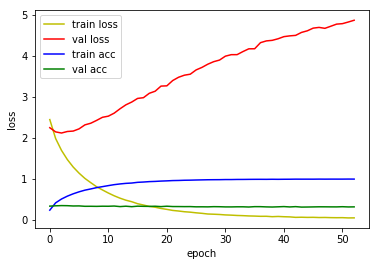

4815/4815 [==============================] - 3s 519us/sample - loss: 2.1382 - acc: 0.3319
Loss: 2.1382002996383305 Accuracy: 0.33187956

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2575 - acc: 0.3009
Epoch 00001: val_loss improved from inf to 1.95516, saving model to model/checkpoint/1D_CNN_custom_DO_2_conv_checkpoint/001-1.9552.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 2.2574 - acc: 0.3010 - val_loss: 1.9552 - val_acc: 0.4186
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7738 - acc: 0.4666
Epoch 00002: val_loss improved from 1.95516 to 1.81058, saving model to model/checkpoint/1D_CNN_custom_DO_2_conv_checkpoint/002-1.8106.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 1.7737 - acc: 0.4666 - val_loss: 1.8106 - val_acc: 0.4510
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5183 - acc: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0971 - acc: 0.9776
Epoch 00029: val_loss did not improve from 1.78155
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0971 - acc: 0.9776 - val_loss: 3.6421 - val_acc: 0.4270
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0931 - acc: 0.9783
Epoch 00030: val_loss did not improve from 1.78155
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0931 - acc: 0.9783 - val_loss: 3.5722 - val_acc: 0.4274
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9783
Epoch 00031: val_loss did not improve from 1.78155
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0942 - acc: 0.9783 - val_loss: 3.6191 - val_acc: 0.4347
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0820 - acc: 0.9822
Epoch 00032: val_loss did not improve from 1.78155
36805/36805 [========================

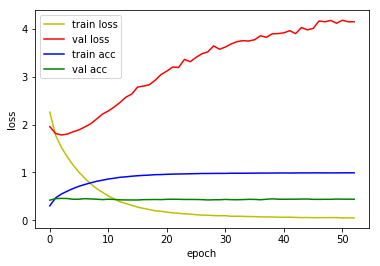

4815/4815 [==============================] - 3s 659us/sample - loss: 1.8384 - acc: 0.4411
Loss: 1.8384307471886354 Accuracy: 0.4411215

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1674 - acc: 0.3195
Epoch 00001: val_loss improved from inf to 1.76617, saving model to model/checkpoint/1D_CNN_custom_DO_3_conv_checkpoint/001-1.7662.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 2.1673 - acc: 0.3195 - val_loss: 1.7662 - val_acc: 0.4559
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5951 - acc: 0.5156
Epoch 00002: val_loss improved from 1.76617 to 1.52934, saving model to model/checkpoint/1D_CNN_custom_DO_3_conv_checkpoint/002-1.5293.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.5950 - acc: 0.5157 - val_loss: 1.5293 - val_acc: 0.5276
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3552 - acc: 0.

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1464 - acc: 0.9574
Epoch 00029: val_loss did not improve from 1.39309
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1463 - acc: 0.9574 - val_loss: 2.0972 - val_acc: 0.6138
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1465 - acc: 0.9573
Epoch 00030: val_loss did not improve from 1.39309
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1464 - acc: 0.9573 - val_loss: 2.1399 - val_acc: 0.6112
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1362 - acc: 0.9612
Epoch 00031: val_loss did not improve from 1.39309
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1362 - acc: 0.9612 - val_loss: 2.1435 - val_acc: 0.6131
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1339 - acc: 0.9632
Epoch 00032: val_loss did not improve from 1.39309
36805/36805 [===========

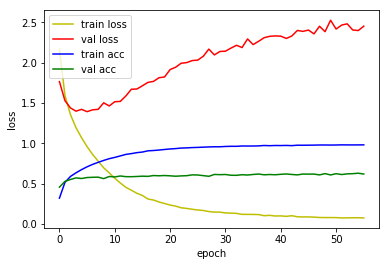

4815/4815 [==============================] - 4s 778us/sample - loss: 1.4752 - acc: 0.5562
Loss: 1.4751907923758834 Accuracy: 0.5561786

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1258 - acc: 0.3139
Epoch 00001: val_loss improved from inf to 1.61264, saving model to model/checkpoint/1D_CNN_custom_DO_4_conv_checkpoint/001-1.6126.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 2.1257 - acc: 0.3139 - val_loss: 1.6126 - val_acc: 0.4934
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5169 - acc: 0.5221
Epoch 00002: val_loss improved from 1.61264 to 1.37533, saving model to model/checkpoint/1D_CNN_custom_DO_4_conv_checkpoint/002-1.3753.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.5170 - acc: 0.5220 - val_loss: 1.3753 - val_acc: 0.5828
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3152 - acc: 0.

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1753 - acc: 0.9433
Epoch 00028: val_loss did not improve from 0.97515
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1753 - acc: 0.9434 - val_loss: 1.1835 - val_acc: 0.7291
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1663 - acc: 0.9455
Epoch 00029: val_loss did not improve from 0.97515
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1663 - acc: 0.9455 - val_loss: 1.2515 - val_acc: 0.7233
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1647 - acc: 0.9484
Epoch 00030: val_loss did not improve from 0.97515
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1647 - acc: 0.9484 - val_loss: 1.2139 - val_acc: 0.7298
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1559 - acc: 0.9522
Epoch 00031: val_loss did not improve from 0.97515
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0837 - acc: 0.9743
Epoch 00058: val_loss did not improve from 0.97515
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0837 - acc: 0.9743 - val_loss: 1.3172 - val_acc: 0.7598
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0874 - acc: 0.9735
Epoch 00059: val_loss did not improve from 0.97515
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0874 - acc: 0.9735 - val_loss: 1.2900 - val_acc: 0.7612
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0797 - acc: 0.9765
Epoch 00060: val_loss did not improve from 0.97515
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0797 - acc: 0.9765 - val_loss: 1.3859 - val_acc: 0.7529
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0779 - acc: 0.9768
Epoch 00061: val_loss did not improve from 0.97515
36805/36805 [===========

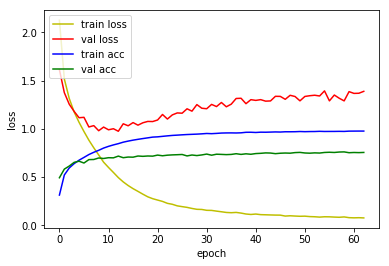

4815/4815 [==============================] - 4s 785us/sample - loss: 1.0685 - acc: 0.6881
Loss: 1.0684766499795646 Accuracy: 0.68805814

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1114 - acc: 0.3073
Epoch 00001: val_loss improved from inf to 1.62311, saving model to model/checkpoint/1D_CNN_custom_DO_5_conv_checkpoint/001-1.6231.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 2.1113 - acc: 0.3074 - val_loss: 1.6231 - val_acc: 0.4680
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5184 - acc: 0.5172
Epoch 00002: val_loss improved from 1.62311 to 1.37160, saving model to model/checkpoint/1D_CNN_custom_DO_5_conv_checkpoint/002-1.3716.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.5185 - acc: 0.5172 - val_loss: 1.3716 - val_acc: 0.5653
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2959 - acc: 0

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2161 - acc: 0.9316
Epoch 00026: val_loss did not improve from 0.72040
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2161 - acc: 0.9316 - val_loss: 0.8165 - val_acc: 0.7976
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2024 - acc: 0.9355
Epoch 00027: val_loss did not improve from 0.72040
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2023 - acc: 0.9355 - val_loss: 0.8019 - val_acc: 0.8020
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1891 - acc: 0.9410
Epoch 00028: val_loss did not improve from 0.72040
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1891 - acc: 0.9410 - val_loss: 0.8016 - val_acc: 0.8069
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1764 - acc: 0.9438
Epoch 00029: val_loss did not improve from 0.72040
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0886 - acc: 0.9721
Epoch 00056: val_loss did not improve from 0.72040
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0887 - acc: 0.9721 - val_loss: 0.9569 - val_acc: 0.8232
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0845 - acc: 0.9746
Epoch 00057: val_loss did not improve from 0.72040
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0845 - acc: 0.9746 - val_loss: 0.8882 - val_acc: 0.8234
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0861 - acc: 0.9723
Epoch 00058: val_loss did not improve from 0.72040
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0861 - acc: 0.9723 - val_loss: 0.9224 - val_acc: 0.8248
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0847 - acc: 0.9739
Epoch 00059: val_loss did not improve from 0.72040
36805/36805 [===========

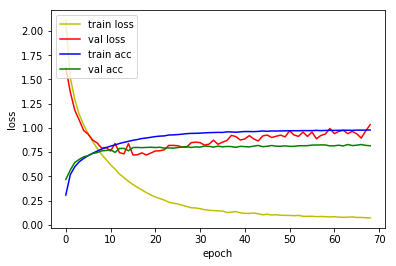

4815/4815 [==============================] - 4s 788us/sample - loss: 0.8442 - acc: 0.7595
Loss: 0.844184148311615 Accuracy: 0.7595016

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2178 - acc: 0.2724
Epoch 00001: val_loss improved from inf to 1.57623, saving model to model/checkpoint/1D_CNN_custom_DO_6_conv_checkpoint/001-1.5762.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 2.2178 - acc: 0.2724 - val_loss: 1.5762 - val_acc: 0.5108
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5468 - acc: 0.5035
Epoch 00002: val_loss improved from 1.57623 to 1.32407, saving model to model/checkpoint/1D_CNN_custom_DO_6_conv_checkpoint/002-1.3241.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.5467 - acc: 0.5035 - val_loss: 1.3241 - val_acc: 0.6019
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3547 - acc: 0.5

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3294 - acc: 0.8985
Epoch 00024: val_loss improved from 0.39944 to 0.38576, saving model to model/checkpoint/1D_CNN_custom_DO_6_conv_checkpoint/024-0.3858.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.3293 - acc: 0.8985 - val_loss: 0.3858 - val_acc: 0.8996
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3153 - acc: 0.9025
Epoch 00025: val_loss did not improve from 0.38576
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.3153 - acc: 0.9025 - val_loss: 0.3875 - val_acc: 0.8991
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3029 - acc: 0.9069
Epoch 00026: val_loss did not improve from 0.38576
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.3029 - acc: 0.9069 - val_loss: 0.4062 - val_acc: 0.8947
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2868 

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1360 - acc: 0.9557
Epoch 00052: val_loss did not improve from 0.35773
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1359 - acc: 0.9557 - val_loss: 0.4020 - val_acc: 0.9119
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1309 - acc: 0.9572
Epoch 00053: val_loss did not improve from 0.35773
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1309 - acc: 0.9572 - val_loss: 0.3978 - val_acc: 0.9133
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9593
Epoch 00054: val_loss did not improve from 0.35773
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1244 - acc: 0.9593 - val_loss: 0.3820 - val_acc: 0.9185
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1228 - acc: 0.9600
Epoch 00055: val_loss did not improve from 0.35773
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0792 - acc: 0.9748
Epoch 00082: val_loss did not improve from 0.35773
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0793 - acc: 0.9748 - val_loss: 0.4206 - val_acc: 0.9203
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0803 - acc: 0.9735
Epoch 00083: val_loss did not improve from 0.35773
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0803 - acc: 0.9735 - val_loss: 0.4570 - val_acc: 0.9119
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0723 - acc: 0.9768
Epoch 00084: val_loss did not improve from 0.35773
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0723 - acc: 0.9769 - val_loss: 0.4518 - val_acc: 0.9154
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9779
Epoch 00085: val_loss did not improve from 0.35773
36805/36805 [===========

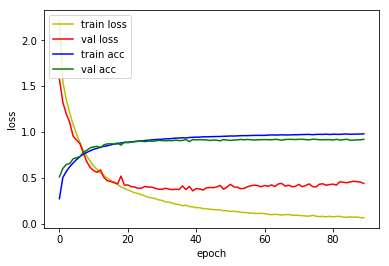

4815/4815 [==============================] - 4s 802us/sample - loss: 0.4309 - acc: 0.8808
Loss: 0.43092903614291767 Accuracy: 0.8807892

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2725 - acc: 0.2494
Epoch 00001: val_loss improved from inf to 1.56733, saving model to model/checkpoint/1D_CNN_custom_DO_7_conv_checkpoint/001-1.5673.hdf5
36805/36805 [==============================] - 70s 2ms/sample - loss: 2.2724 - acc: 0.2494 - val_loss: 1.5673 - val_acc: 0.4852
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5238 - acc: 0.4950
Epoch 00002: val_loss improved from 1.56733 to 1.22385, saving model to model/checkpoint/1D_CNN_custom_DO_7_conv_checkpoint/002-1.2239.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.5240 - acc: 0.4950 - val_loss: 1.2239 - val_acc: 0.6331
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2696 - acc: 0

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2473 - acc: 0.9220
Epoch 00025: val_loss improved from 0.23241 to 0.22456, saving model to model/checkpoint/1D_CNN_custom_DO_7_conv_checkpoint/025-0.2246.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2473 - acc: 0.9220 - val_loss: 0.2246 - val_acc: 0.9350
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2397 - acc: 0.9232
Epoch 00026: val_loss improved from 0.22456 to 0.21610, saving model to model/checkpoint/1D_CNN_custom_DO_7_conv_checkpoint/026-0.2161.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2397 - acc: 0.9232 - val_loss: 0.2161 - val_acc: 0.9359
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2303 - acc: 0.9260
Epoch 00027: val_loss did not improve from 0.21610
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2305 - acc: 0.9259 - val_loss: 0.2638 - val_acc: 0

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1165 - acc: 0.9613
Epoch 00053: val_loss did not improve from 0.18452
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1165 - acc: 0.9613 - val_loss: 0.2009 - val_acc: 0.9504
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1159 - acc: 0.9609
Epoch 00054: val_loss did not improve from 0.18452
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1160 - acc: 0.9608 - val_loss: 0.1994 - val_acc: 0.9504
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1184 - acc: 0.9600
Epoch 00055: val_loss did not improve from 0.18452
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1184 - acc: 0.9600 - val_loss: 0.1892 - val_acc: 0.9490
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1056 - acc: 0.9643
Epoch 00056: val_loss did not improve from 0.18452
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0695 - acc: 0.9757
Epoch 00083: val_loss did not improve from 0.18452
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0696 - acc: 0.9757 - val_loss: 0.2135 - val_acc: 0.9548
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0692 - acc: 0.9769
Epoch 00084: val_loss did not improve from 0.18452
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0692 - acc: 0.9769 - val_loss: 0.2328 - val_acc: 0.9518
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0634 - acc: 0.9779
Epoch 00085: val_loss did not improve from 0.18452
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0635 - acc: 0.9779 - val_loss: 0.2075 - val_acc: 0.9543
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.9783
Epoch 00086: val_loss did not improve from 0.18452
36805/36805 [===========

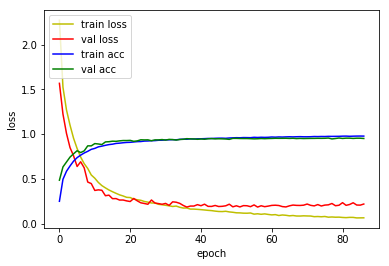

4815/4815 [==============================] - 4s 844us/sample - loss: 0.2148 - acc: 0.9394
Loss: 0.21475390930846722 Accuracy: 0.9393562

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2630 - acc: 0.2534
Epoch 00001: val_loss improved from inf to 1.43848, saving model to model/checkpoint/1D_CNN_custom_DO_8_conv_checkpoint/001-1.4385.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 2.2628 - acc: 0.2534 - val_loss: 1.4385 - val_acc: 0.5565
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3804 - acc: 0.5557
Epoch 00002: val_loss improved from 1.43848 to 0.95788, saving model to model/checkpoint/1D_CNN_custom_DO_8_conv_checkpoint/002-0.9579.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.3803 - acc: 0.5558 - val_loss: 0.9579 - val_acc: 0.7032
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0775 - acc: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.2089 - acc: 0.9321
Epoch 00023: val_loss did not improve from 0.15334
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.2089 - acc: 0.9321 - val_loss: 0.1609 - val_acc: 0.9548
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2023 - acc: 0.9351
Epoch 00024: val_loss improved from 0.15334 to 0.14559, saving model to model/checkpoint/1D_CNN_custom_DO_8_conv_checkpoint/024-0.1456.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.2023 - acc: 0.9351 - val_loss: 0.1456 - val_acc: 0.9595
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1945 - acc: 0.9375
Epoch 00025: val_loss did not improve from 0.14559
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1945 - acc: 0.9375 - val_loss: 0.1704 - val_acc: 0.9467
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1936 - acc: 0.9379

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0946 - acc: 0.9676
Epoch 00051: val_loss did not improve from 0.12089
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0946 - acc: 0.9676 - val_loss: 0.1357 - val_acc: 0.9602
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0931 - acc: 0.9688
Epoch 00052: val_loss did not improve from 0.12089
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0931 - acc: 0.9688 - val_loss: 0.1282 - val_acc: 0.9637
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0885 - acc: 0.9703
Epoch 00053: val_loss did not improve from 0.12089
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0885 - acc: 0.9703 - val_loss: 0.1358 - val_acc: 0.9630
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0894 - acc: 0.9691
Epoch 00054: val_loss did not improve from 0.12089
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9825
Epoch 00080: val_loss did not improve from 0.11300
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0525 - acc: 0.9825 - val_loss: 0.1323 - val_acc: 0.9672
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9829
Epoch 00081: val_loss did not improve from 0.11300
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0495 - acc: 0.9829 - val_loss: 0.1221 - val_acc: 0.9697
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0500 - acc: 0.9832
Epoch 00082: val_loss did not improve from 0.11300
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0500 - acc: 0.9832 - val_loss: 0.1267 - val_acc: 0.9697
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9827
Epoch 00083: val_loss did not improve from 0.11300
36805/36805 [========================

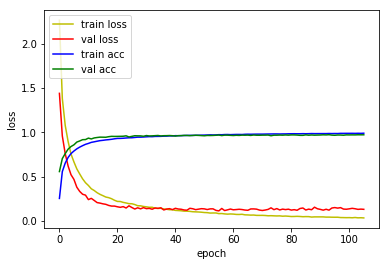

4815/4815 [==============================] - 5s 942us/sample - loss: 0.1764 - acc: 0.9479
Loss: 0.1763709456370689 Accuracy: 0.9478712

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0728 - acc: 0.3284
Epoch 00001: val_loss improved from inf to 1.22667, saving model to model/checkpoint/1D_CNN_custom_DO_9_conv_checkpoint/001-1.2267.hdf5
36805/36805 [==============================] - 75s 2ms/sample - loss: 2.0727 - acc: 0.3284 - val_loss: 1.2267 - val_acc: 0.6301
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0761 - acc: 0.6482
Epoch 00002: val_loss improved from 1.22667 to 0.71116, saving model to model/checkpoint/1D_CNN_custom_DO_9_conv_checkpoint/002-0.7112.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0761 - acc: 0.6482 - val_loss: 0.7112 - val_acc: 0.7831
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7823 - acc: 0.

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1100 - acc: 0.9633
Epoch 00026: val_loss did not improve from 0.12109
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1100 - acc: 0.9633 - val_loss: 0.1398 - val_acc: 0.9574
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1015 - acc: 0.9663
Epoch 00027: val_loss did not improve from 0.12109
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1015 - acc: 0.9663 - val_loss: 0.1377 - val_acc: 0.9569
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0999 - acc: 0.9660
Epoch 00028: val_loss did not improve from 0.12109
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0999 - acc: 0.9660 - val_loss: 0.1257 - val_acc: 0.9620
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0946 - acc: 0.9683
Epoch 00029: val_loss did not improve from 0.12109
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9877
Epoch 00056: val_loss did not improve from 0.12063
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0350 - acc: 0.9877 - val_loss: 0.1389 - val_acc: 0.9690
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9875
Epoch 00057: val_loss did not improve from 0.12063
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0360 - acc: 0.9875 - val_loss: 0.1505 - val_acc: 0.9653
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9880
Epoch 00058: val_loss did not improve from 0.12063
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0367 - acc: 0.9880 - val_loss: 0.1501 - val_acc: 0.9672
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9885
Epoch 00059: val_loss did not improve from 0.12063
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0211 - acc: 0.9930
Epoch 00086: val_loss did not improve from 0.12063
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0211 - acc: 0.9930 - val_loss: 0.1937 - val_acc: 0.9641
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9929
Epoch 00087: val_loss did not improve from 0.12063
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0212 - acc: 0.9929 - val_loss: 0.1773 - val_acc: 0.9623
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9940
Epoch 00088: val_loss did not improve from 0.12063
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0195 - acc: 0.9940 - val_loss: 0.1782 - val_acc: 0.9676

1D_CNN_custom_DO_9_conv Model


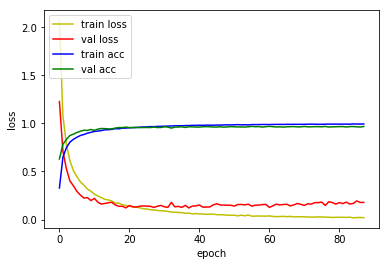

4815/4815 [==============================] - 4s 910us/sample - loss: 0.1941 - acc: 0.9464
Loss: 0.19408866517624876 Accuracy: 0.94641745



In [12]:
for i in range(1, 10):
    base = '1D_CNN_custom_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [13]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 3s 596us/sample - loss: 2.1382 - acc: 0.3319
Loss: 2.1382002996383305 Accuracy: 0.33187956

1D_CNN_custom_DO_2_conv Model
________________________________________________________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4309 - acc: 0.8808
Loss: 0.43092903614291767 Accuracy: 0.8807892

1D_CNN_custom_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 6

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1941 - acc: 0.9464
Loss: 0.19408866517624876 Accuracy: 0.94641745


In [14]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 3s 696us/sample - loss: 4.9242 - acc: 0.3040
Loss: 4.924214981154366 Accuracy: 0.30404985

1D_CNN_custom_DO_2_conv Model
_________________________________________________________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.5348 - acc: 0.8901
Loss: 0.5347867643636645 Accuracy: 0.890135

1D_CNN_custom_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 1777, 64)

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2644 - acc: 0.9537
Loss: 0.26437774926195035 Accuracy: 0.9536864
